In [91]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ipywidgets import interact, interact_manual
from scipy.fft import fft, ifft
from IPython.display import HTML

In [90]:
# we will work with cosine with frequency 0.5
def create_cosine_samples(sampling_frequency: int, length: int, cos_func):
    sampling_rate = 1 / sampling_frequency
    n_samples = int(length / sampling_rate) + 1
    x_axis = np.array([sampling_rate * i for i in range(n_samples)])
    y_axis = cos_func(x_axis)
    return x_axis, y_axis

def create_cosine(length: int, cos_func):
    x_axis = np.linspace(0, length, 2000)
    y_axis = cos_func(x_axis)
    return x_axis, y_axis

In [94]:
def sig_plot(
    ax,
    fig,
    ix,
    xs,
    ys,
    x_axis,
    y_axis
):
    ax.plot(x_axis, y_axis)
    ax.set_title('Original signal')
    fig.axes[ix].set_ylabel('Amplitude')
    fig.axes[ix].set_xlabel('Time')
    ax.plot(xs, ys, 'ro')

def freq_plot(
    ax,
    fig,
    ix,
    freqs,
    magnitudes
):
    ax.plot(freqs, magnitudes, 'ok')
    ax.set_title('Spectral Analysis')
    fig.axes[ix].set_ylabel('Magnitude')
    fig.axes[ix].set_xlabel('Frequency')
    ax.grid()

def angle_plot(
    ax,
    fig,
    ix,
    freqs,
    angles
):
    ax.plot(freqs, angles, 'ok')
    ax.set_title('Phase Shifts')
    fig.axes[ix].set_ylabel('Phase')
    fig.axes[ix].set_xlabel('Frequency')
    ax.grid()
    

def create_plot(
    xs,
    ys,
    freqs,
    magnitudes,
    angles,
    length,
    cos_func
):
    x_axis, y_axis = create_cosine(length, cos_func)
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(20, 15)
    fig.set_dpi(300)
    sig_plot(ax1, fig, 0, xs, ys, x_axis, y_axis)
    plt.grid()
    freq_plot(ax2, fig, 1, freqs, magnitudes)
#     angle_plot(ax3, fig, 2, freqs, angles)
#     plt.grid()
    plt.show()

def transform_to_polar(fft_ys, sample_freq):
    freqs = []
    magnitudes = []
    angles = []
    n_samples = len(fft_ys)
    for i in range(n_samples):
        freq = i * 1 / n_samples * sample_freq
        magnitude = np.absolute(fft_ys[i])
        angle = np.angle(fft_ys[i]) if np.abs(magnitude) > 1e-7 else 0
        freqs.append(freq)
        magnitudes.append(magnitude)
        angles.append(angle)
    return freqs, magnitudes, angles

def cosine_fft_visualization(
    sample_freq,
    cos_freq,
    phase_shift,
    power_of_two
):
    length = (2 ** power_of_two) - 0.5
    cos_func = lambda x: np.cos(x * (2 * np.pi) *  cos_freq + phase_shift)
    xs, ys = create_cosine_samples(sample_freq, length, cos_func)
    fft_ys = fft(ys)
    #print(fft_ys)
    freqs, magnitudes, angles = transform_to_polar(fft_ys, sample_freq)
    
    create_plot(xs, ys, freqs, magnitudes, angles, length, cos_func)

# Spectral Analysis

- the main aim of this notebook is to play with the spectral analysis using Discrete Fourier Transform, to be able to understand it better in order to apply it later
- it is in no way mathematically rigorous and it doesn't intend to be

## Discrete Fourier Transform

- [reference 1](https://www.chciken.com/digital/signal/processing/2020/04/13/dft.html), [reference 2](https://ccrma.stanford.edu/~jos/st/FFT_Simple_Sinusoid.html)
- we have a continuous signal $x(t), t \in \mathbb{R}$, and we sample it in $N$ points $p_0, \dots, p_{N - 1}$ and get a sequence $\{x(p_n)\}_{n = 0}^{N - 1}$
- Discrete Fourier Transform transforms $N$-dimensional vector $x_i = x(p_i)$ to $N$-dimensional vector $y_j = \sum_{n = 0}^{N - 1} e^{\frac{2\pi i j n}{N}} x_n$, $y_j$ is sometimes called $j$-th DFT coefficient
- according to _reference 1_ this means that $j$-th coefficient shows how much does $e^{\frac{2\pi i j n}{N}}$ contribute to the signal
    - this is coefficient of normalized frequency $\frac{j}{N}$ (normalized as cycles per sample), which means that the true frequency is $\frac{j}{N} f_s$, where $f_s$ is the sample frequency 

### Cosine Function (Sanity Check 1)
- we work with a continuous signal $cos(2\pi f_c x)$, where $f_c$ is the cosine frequency, $x \in \mathbb{R}$
- the signal would be sampled with a sample frequency $f_s$, on interval $[0, T)$
- hence the points would be in form $\{(\frac{n}{f_s}, cos(2\pi f_c \frac{n}{f_s}) )\}_{n = 0}^{T * f_s}$

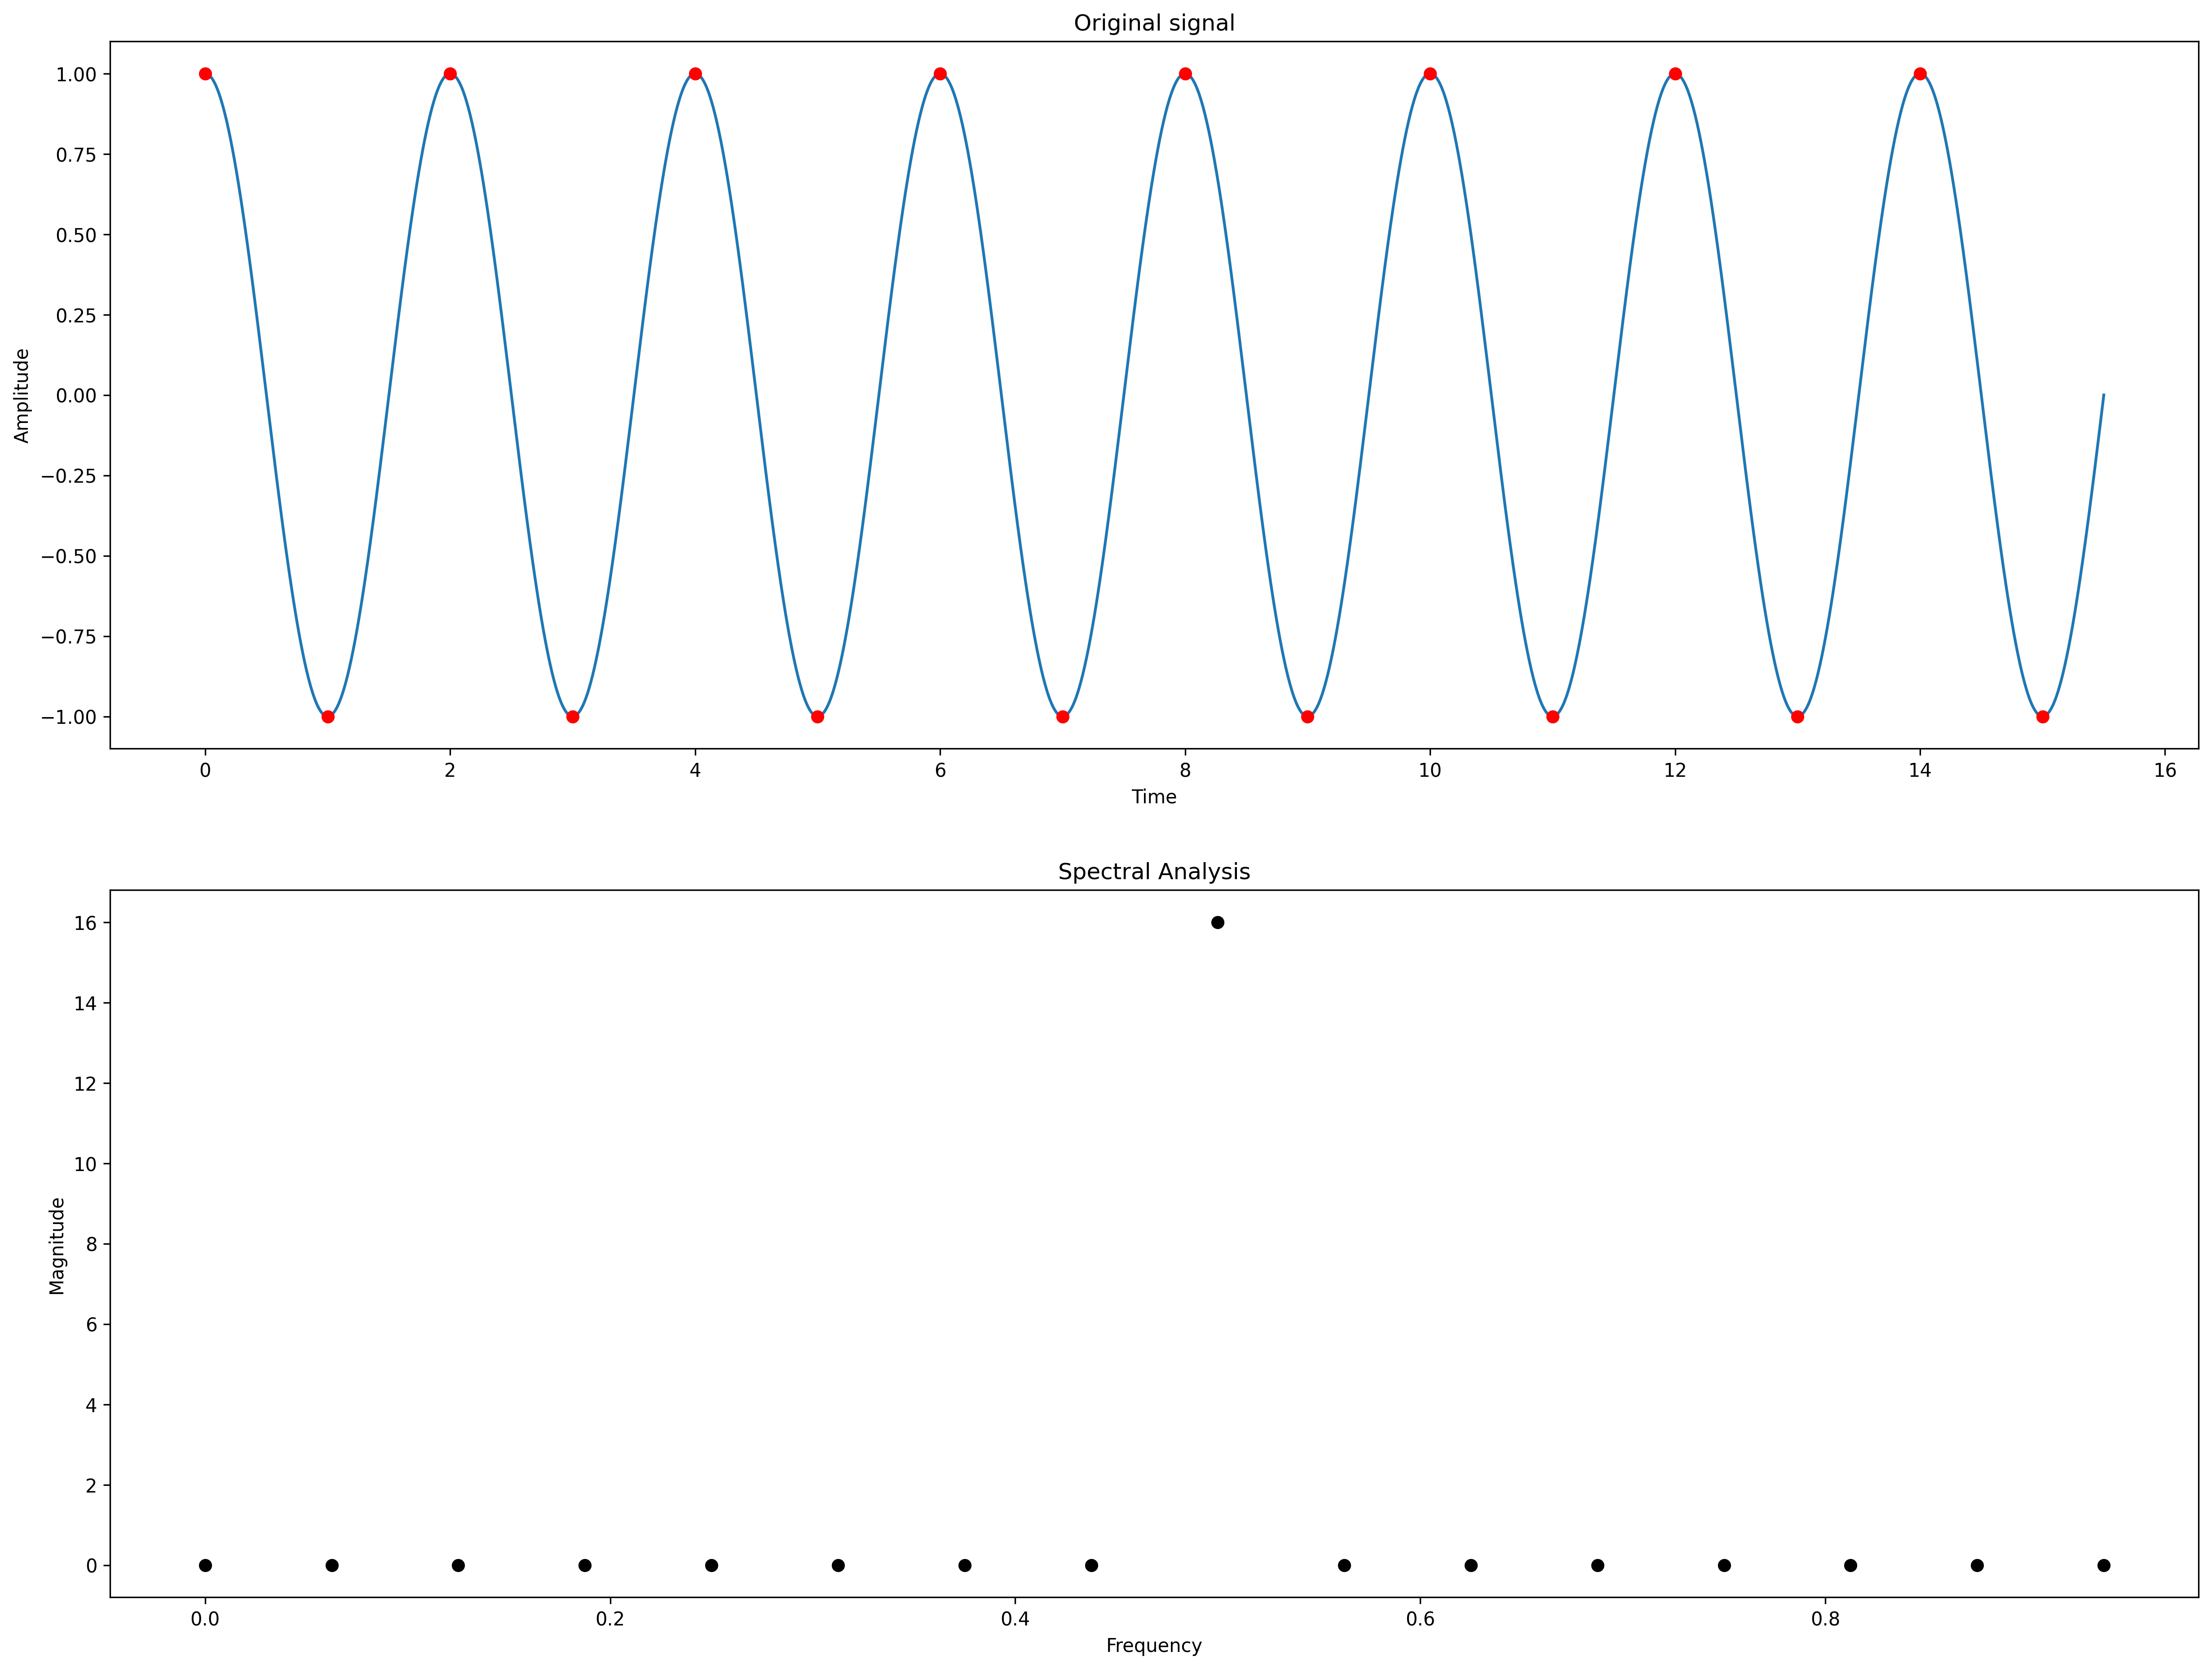

In [99]:
cosine_fft_visualization(sample_freq=1.0, cos_freq=0.5, phase_shift=0, power_of_two=4)

We see that the spectral analysis correctly found that the frequency of the cosine function is $0.5$

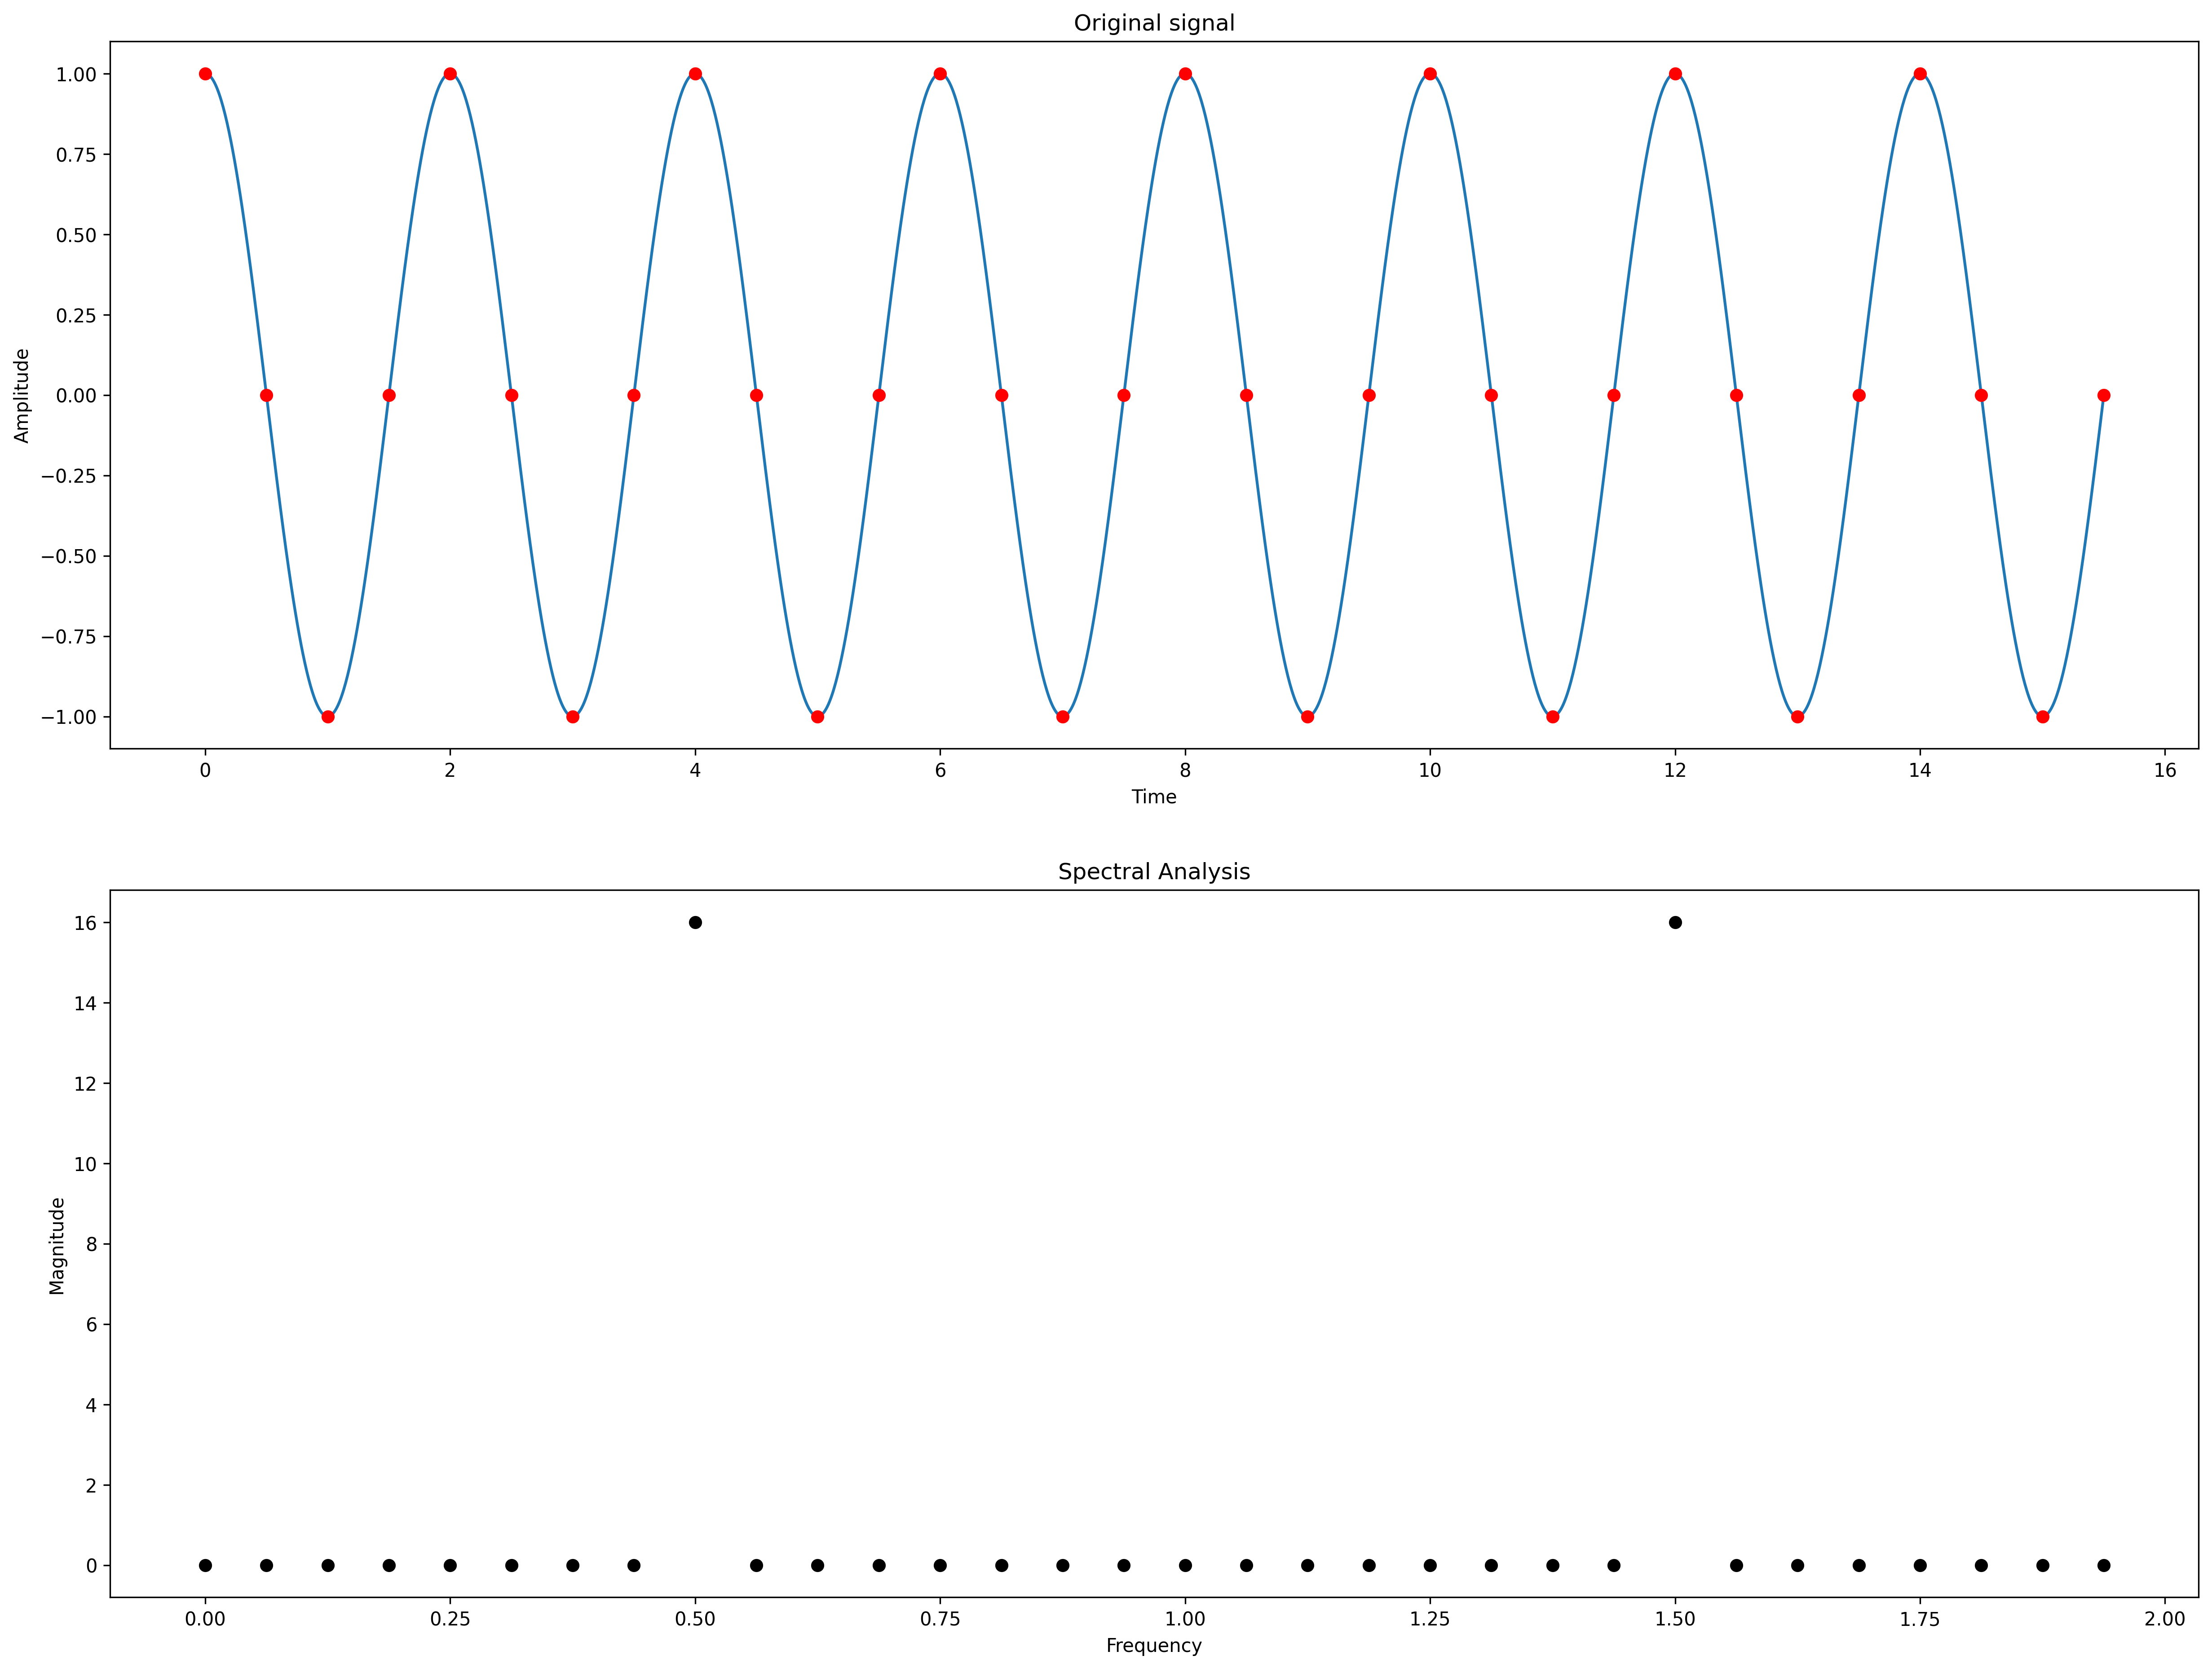

In [98]:
cosine_fft_visualization(sample_freq=2.0, cos_freq=0.5, phase_shift=0, power_of_two=4)

We see that the spectral analysis correctly found one frequency peak at 0.5 but we also see one frequency peak at 1.5. At first lets transform the frequencies $f$ to normalized frequencies $f_n = \frac{f}{f_s}$, the peaks are now on 0.25 and 0.75,

These frequencies correspond to complex-conjugated terms of DFT (see _reference 1_), as there are in fact 2 complex oscillations in the signal, however they add up to real number, so in fact we can discard the other one (sort of).

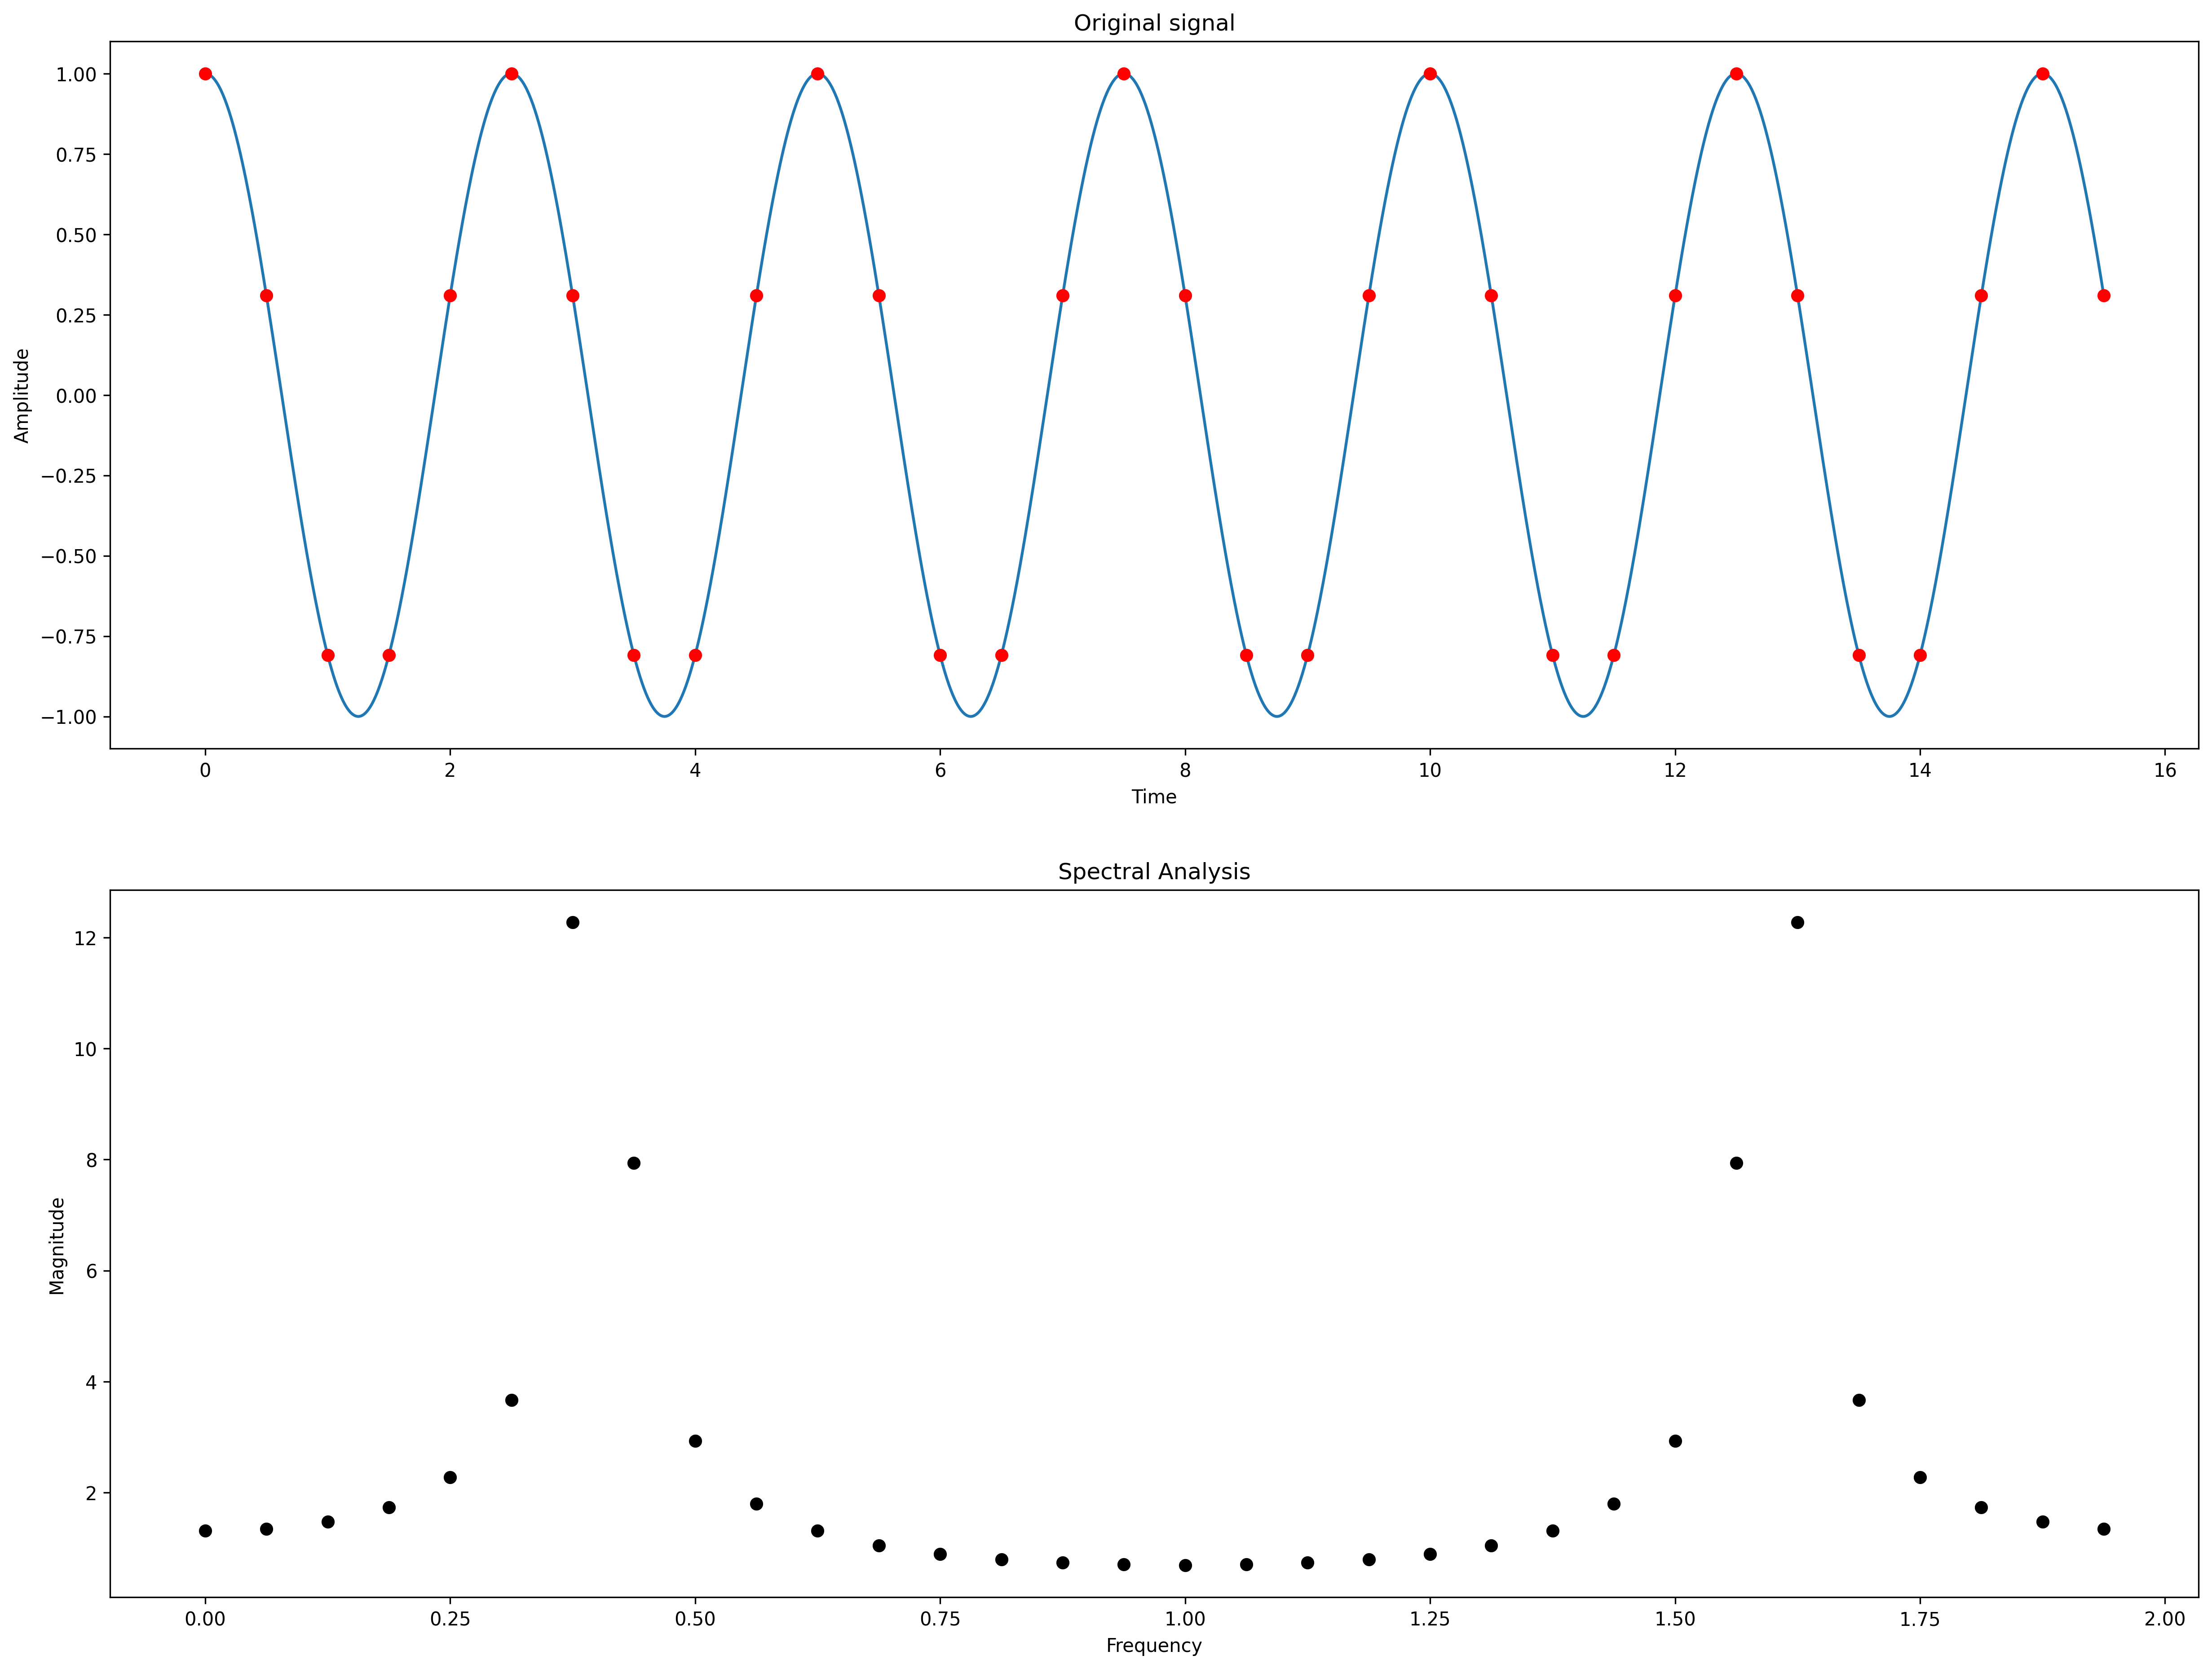

In [97]:
cosine_fft_visualization(sample_freq=2.0, cos_freq=0.4, phase_shift=0, power_of_two=4)

Now we see that the result isn't in any means exact. The peaks are near 0.4, but not as exact as in the previous cases (where the peaks were the only non-zero points on the graph).

This is because the oscillation at 0.4 isn't present in the DFT coefficients which are of form $n/N$ where $N$ is 32. The closest values are $\frac{6}{32} * 2 = 0.375$ and $\frac{7}{32} * 2 = 0.4375$ and complex-conjugated indices 25 and 26 (indices start with 0, $f_s = 2$). Hence the spectral analysis needs to find linear combination of available frequencies and cannot be as exact.

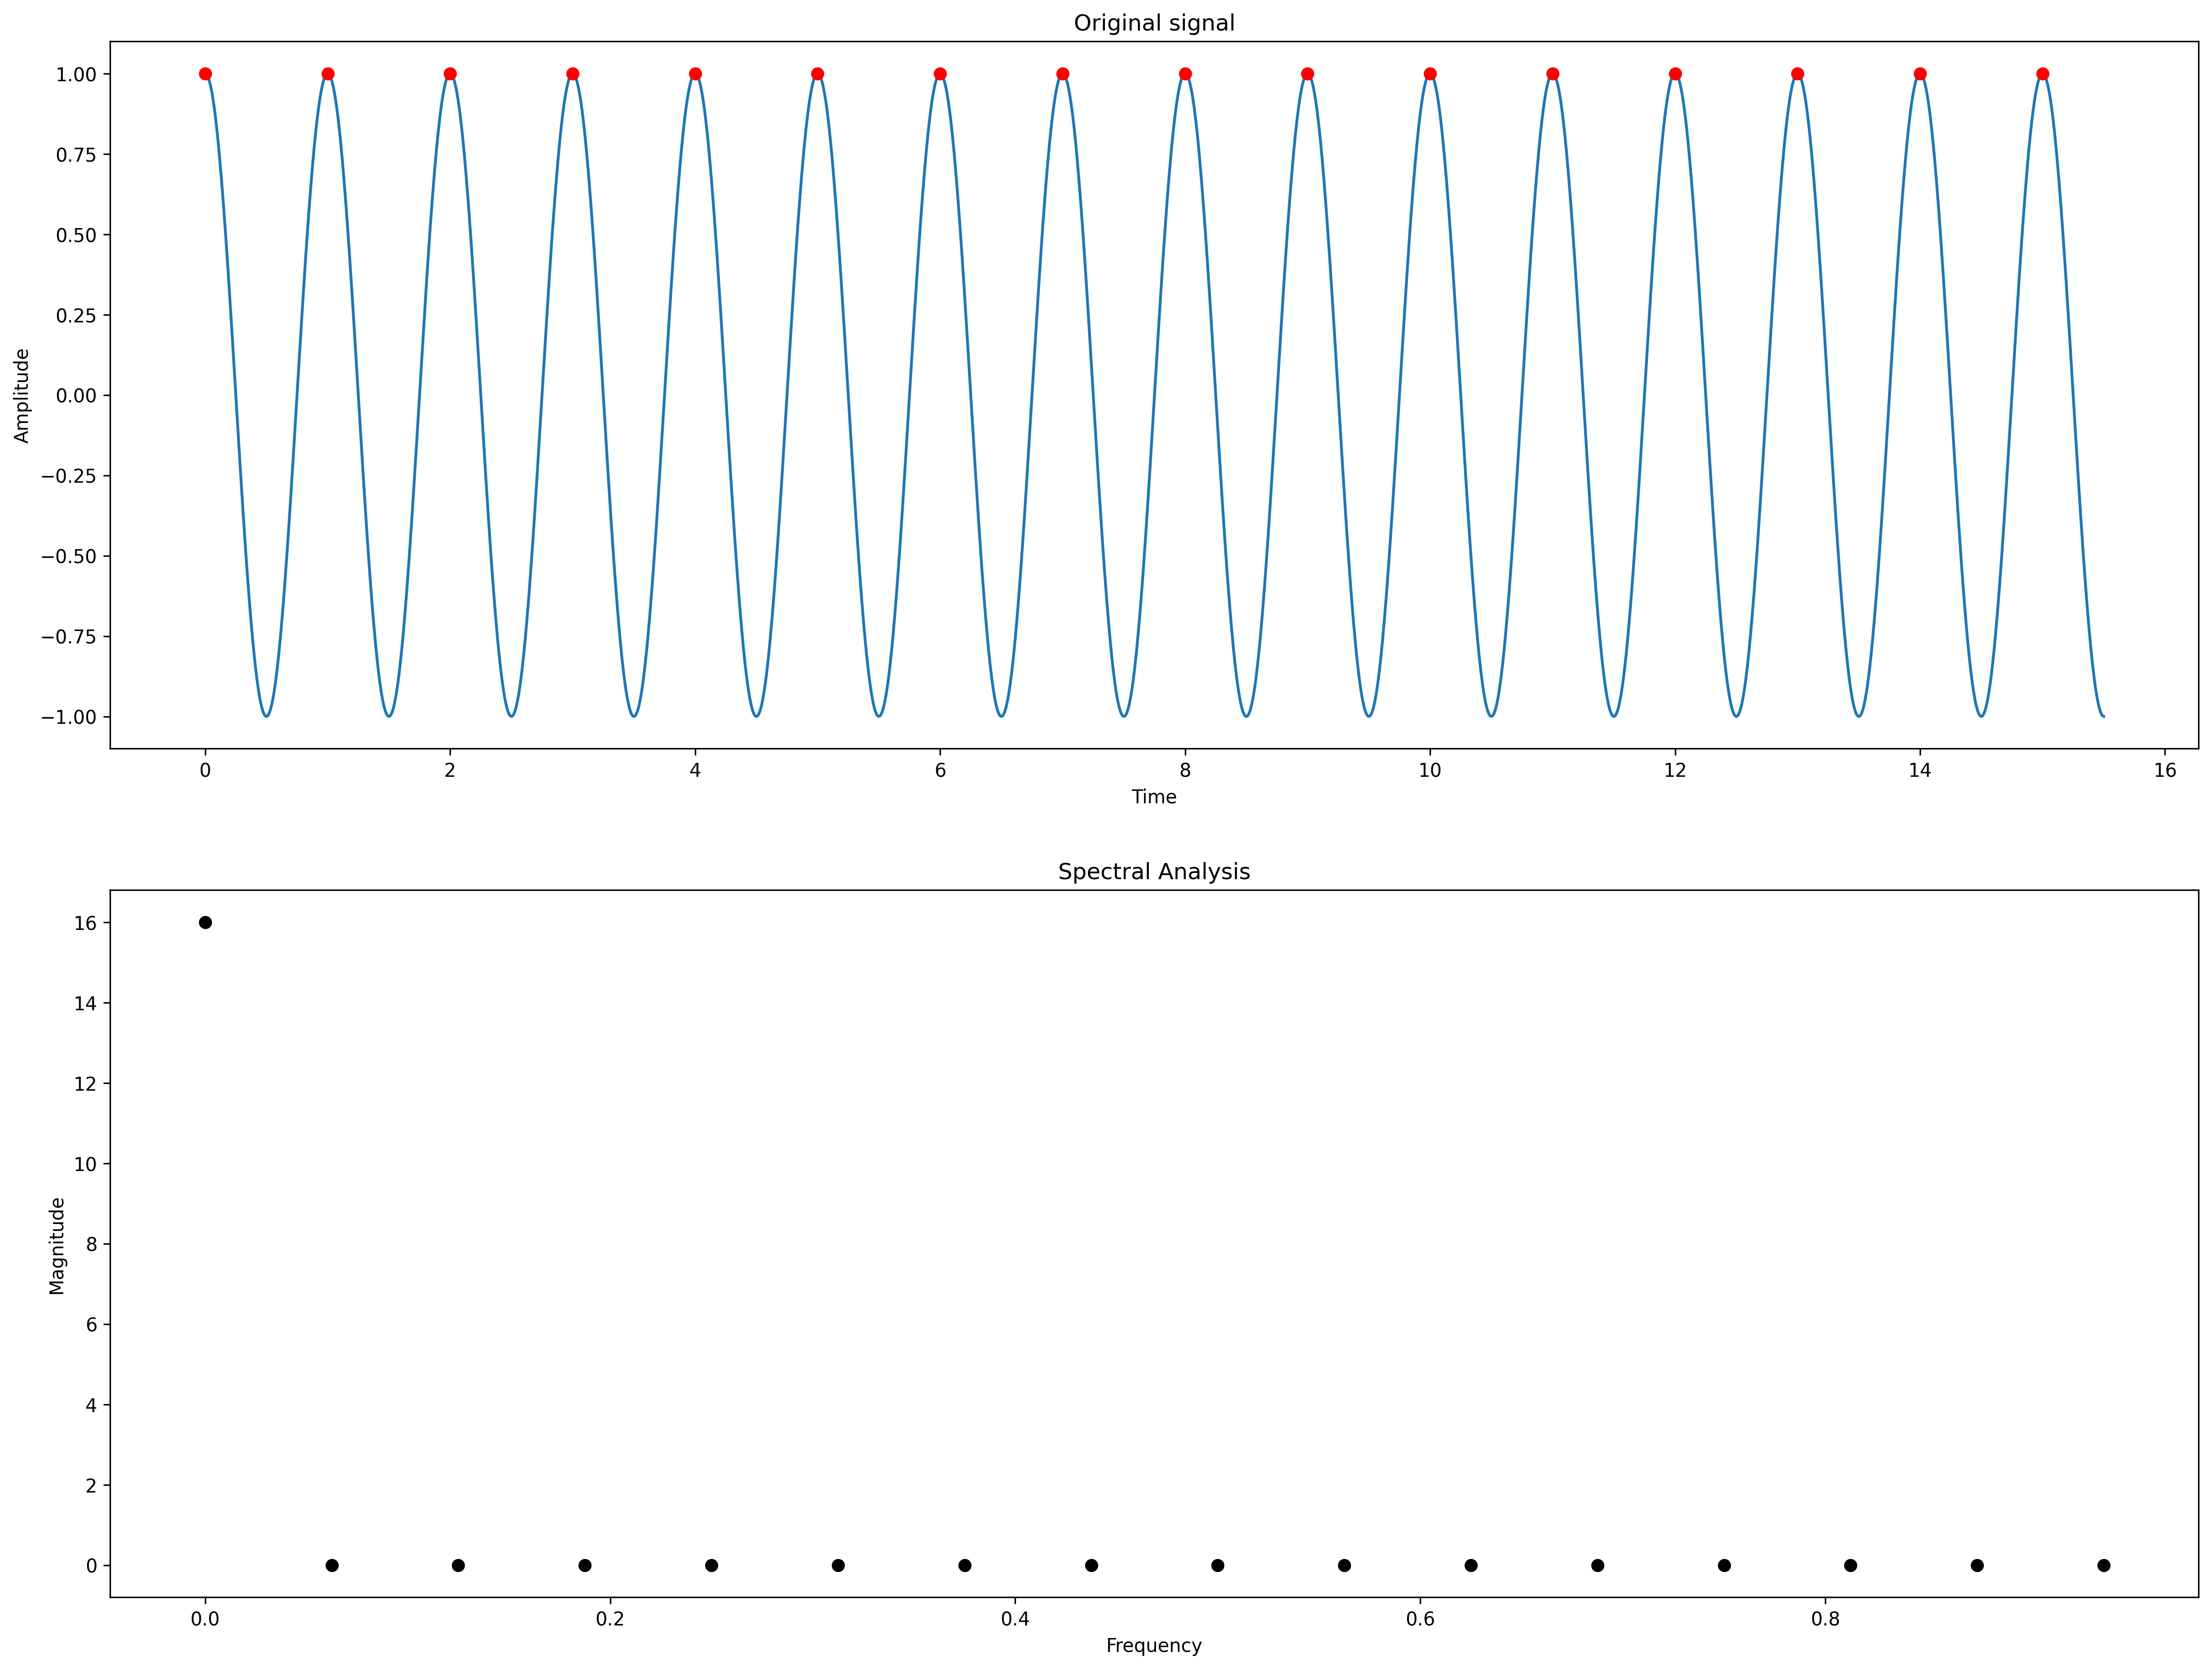

In [96]:
cosine_fft_visualization(sample_freq=1.0, cos_freq=1.0, phase_shift=0, power_of_two=4)

Another interesting phenomenon happens when sampling frequency $f_s$ is below $2 f_c$ (2-times cosine frequency). Then according to Shannon's Sampling Theorem, the original signal cannot be exactly recovered.

In the example we see that with $f_s = f_c$ the Spectral Analysis finds only constant oscillation $cos(0x)$.

## Interactive Example
- here you can play with cosine frequency $f_c$ and sampling frequency $f_s$ to see possible spectral analysis for the first sanity check

In [95]:
@interact
def cosine_fft_test(
    sample_freq=(0.2, 5.0, 0.1),
    cos_freq=(0.1, 1.0, 0.01),
    phase_shift=(0, 2*np.pi, np.pi / 8)
):
    cosine_fft_visualization(sample_freq, cos_freq, phase_shift, 3)


interactive(children=(FloatSlider(value=2.5000000000000004, description='sample_freq', max=5.0, min=0.2), Floa…

In [85]:
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio

camera = CameraStream(
    constraints={
        'audio': True,
        'video': False
})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

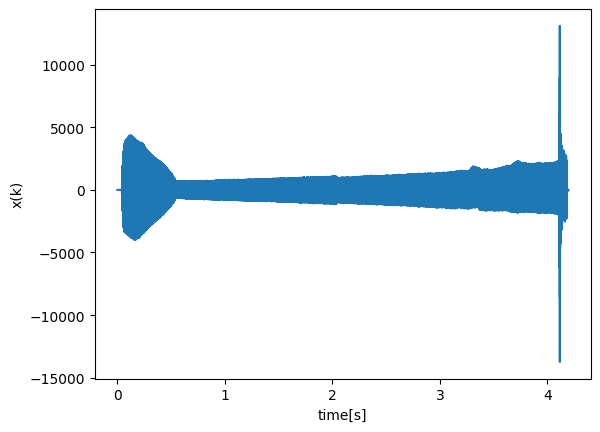

In [86]:
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
recorder.save('spectral_analysis_sound.webm')
!ffmpeg -i spectral_analysis_sound.webm -ac 1 -f wav spectral_analysis_sound.wav -y -hide_banner -loglevel panic
sampleFreq, recording = scipy.io.wavfile.read("spectral_analysis_sound.wav")
sampleDur = len(recording)/sampleFreq

timeX = np.arange(0,sampleDur, 1/sampleFreq)
recording = recording[:len(timeX)]
timeX = timeX[:len(recording)]

plt.plot(timeX, recording)
plt.ylabel('x(k)')
plt.xlabel('time[s]')
plt.show()

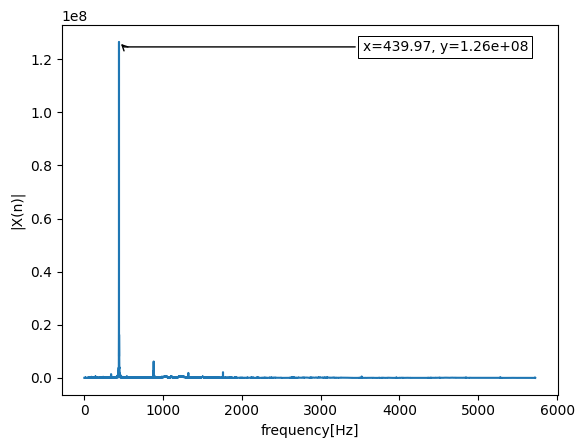

In [109]:
betterRecording = recording
absFreqSpectrum = np.abs(fft(betterRecording))

# from DFT index to frequency: index / total_samples * sample_freq
freqs = np.array([i / len(absFreqSpectrum) * sampleFreq for i in range(sampleFreq // 2)])
absFreqSpectrum = absFreqSpectrum[:sampleFreq // 2]

plt.plot(freqs, absFreqSpectrum)

# annotate the maximum
ax = plt.gca()
max_x = np.argmax(absFreqSpectrum) / len(betterRecording) * sampleFreq
max_y = np.max(absFreqSpectrum)
text = f"x={max_x:.2f}, y={max_y:.2e}"
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=-45")
kw = dict(xycoords='data',textcoords="axes fraction",
          arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
ax.annotate(text, xy=(max_x, max_y), xytext=(0.94,0.96), **kw)

# create plot
plt.ylabel('|X(n)|')
plt.xlabel('frequency[Hz]')
plt.show()

In [88]:
top_frequencies = [(freq / len(betterRecording) * sampleFreq, f"{amp:.2e}") for freq, amp in enumerate(absFreqSpectrum) if amp > 1e8 * 0.3]

top_frequencies

[(439.48968641945874, '3.09e+07'),
 (439.7281507094313, '4.49e+07'),
 (439.9666149994038, '1.26e+08')]